# MATH50003 (2022–23)
# Lab 3: Divided differences and dual numbers

This lab explores different discretisations for first and higher derivatives.
In particular we consider the following approximations:
*Forward differences*:
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
*Central differences*:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
*Second order differences*:
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
We also add to the implementation of `Dual` to enable
automatic differentiation with cos, sin, and division

In [6]:
using Plots, Test
# helper function to avoid trying to take logs of 0 in plots
# use in plots below
nanabs(x) = iszero(x) ? NaN : abs(x)

nanabs (generic function with 1 method)

--------

**Problem 1** Implement central differences
for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$, approximating the derivative at $x = 0$.
Plot the absolute errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`.

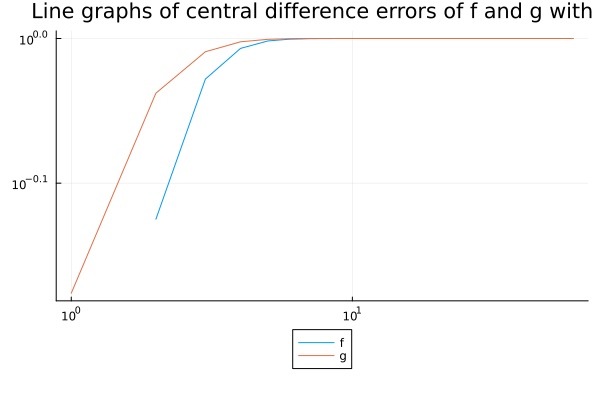

In [22]:
# define functions
f = x -> 1 + x + x^2
g = x -> 1 + (1/3)*x + x^2

# define analytic derivatives
df = x -> 1 + 2*x
dg = x -> (1/3) + 2*x

# central differences difference approximation
centraldiff(x, h, f) = (f(x+h)-f(x-h))/2*h

# computes an error
centraldifferror(x, h, f, df) = abs(centraldiff(x, h, f) - df(x))

# plotting the central differences
x = 0.0
h = 2.0 .^ (0:-1:-60)
plot(nanabs.(centraldifferror.(x, h, f, df)), yaxis =:log10, xaxis =:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, df)), yaxis =:log10, xaxis =:log10, label="g")
plot!(legend=:outerbottom)
title!("Line graphs of central difference errors of f and g with h")


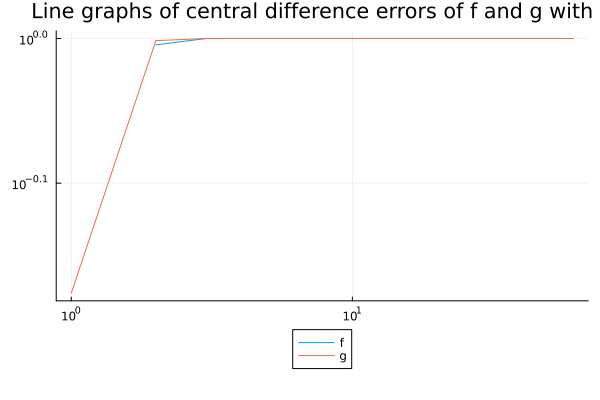

In [23]:
h = 10.0 .^ (0:-1:-60)
plot(nanabs.(centraldifferror.(x, h, f, df)), yaxis =:log10, xaxis =:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, df)), yaxis =:log10, xaxis =:log10, label="g")
plot!(legend=:outerbottom)
title!("Line graphs of central difference errors of f and g with h")


-----
**Problem 2** Use forward differences, central differences, and second-order divided differences to approximate to 5-digits the first and second
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$

In [32]:
# forward difference
forwarddiff(x, h, f) = (f(x+h) - f(x))/h

# central difference
centraldiff(x, h, f) = (f(x+h)-f(x-h))/(2*h)

# second order divided difference
seconddiff(x, h, f) = (f(x+h) - 2*f(x) + f(x-h))/(h^2)

# define the functions
f = x-> exp(exp(x)*cos(x) + sin(x))
g = x-> prod([x] ./ (1:1000) .- 1)
function cont(n, x)
    ret = 2*one(x)
    for k = 1:n-1
        ret = 2 + (x-1)/ret
    end
    1 + (x-1)/ret
end

# set the point
x = 0.1

ϵ_m = eps()

# values for function f
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(ϵ_m), f))
println("f'($x) with central difference: ", centraldiff(x, cbrt(ϵ_m), f))
println("f''($x) with second order difference: ", seconddiff(x, cbrt(ϵ_m), f))

f'(0.1) with forward difference: 6.584772557020187
f'(0.1) with central difference: 6.5847725545726465
f''(0.1) with second order difference: 12.002673711904597


----

In [33]:
# values for function g
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(ϵ_m), g))
println("f'($x) with central difference: ", centraldiff(x, cbrt(ϵ_m), g))
println("f''($x) with second order difference: ", seconddiff(x, cbrt(ϵ_m), g))

f'(0.1) with forward difference: -3.593826290220022
f'(0.1) with central difference: -3.5938265143003103
f''(0.1) with second order difference: 26.638575417204954


In [36]:
# values for cont function
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(ϵ_m), x->cont(1000, x)))
println("f'($x) with central difference: ", centraldiff(x, cbrt(ϵ_m), x->cont(1000, x)))
println("f''($x) with second order difference: ", seconddiff(x, cbrt(ϵ_m), x->cont(1000, x)))

f'(0.1) with forward difference: 1.5811387598514557
f'(0.1) with central difference: 1.5811388308012815
f''(0.1) with second order difference: -7.905698560322122


**Problem 3.1** Add support for `cos`, `sin`, and `/` to the type `Dual`:

In [38]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

function cos(x::Dual)
    # TODO: implement cos for Duals
    Dual(cos(x.a), -(x.b)*sin(x.a))
end

function sin(x::Dual)
    # TODO: implement sin for Duals
    Dual(sin(x.a), (x.b)*cos(x.a))

end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals
    Dual((x.a)/(y.a), ((x.b)*(y.a) - (x.a)*(y.b))/((y.a)^2))

end

x = 0.1
@test cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Passed

**Problem 3.2** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 2?

In [43]:
x = 0.1
fdual = f(0.1+ϵ)
gdual = g(0.1+ϵ)
contdual = cont(1000, 0.1+ϵ)
println("f'($x) with dual numbers: ", fdual.b)
println("g'($x) with dual numbers: ", gdual.b)
println("h'($x) with dual numbers: ", contdual.b)
println("computing the derivatives with dual numbers provides us with the same results to 5sf")

f'(0.1) with dual numbers: 6.5847725546108276
g'(0.1) with dual numbers: -3.593826513101571
h'(0.1) with dual numbers: 1.5811388300841893
computing the derivatives with dual numbers provides us with the same results to 5sf


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*